In [11]:
import sqlalchemy
import pandas as pd


In [12]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['Indicators', 'TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Info']


In [13]:
indicators_df = pd.read_sql_table('Indicators', con=engine, index_col='Datetime')

In [14]:
print(indicators_df.head())

                       Open    High     Low  Close  Volume  CDLDOJI  \
Datetime                                                              
2021-09-03 03:52:00  730.53  730.60  730.50  730.6    2273        0   
2021-09-03 03:53:00  730.51  730.51  729.99  730.0    7418        0   
2021-09-03 03:54:00  731.48  731.80  729.80  729.8    3327        0   
2021-09-03 03:55:00  729.12  730.00  729.00  729.9    2946        0   
2021-09-03 03:56:00  730.00  730.50  730.00  730.5    1065        0   

                     Trailing Stop  Trade Signal  Pct Change   Stop Loss  
Datetime                                                                  
2021-09-03 03:52:00     728.544643           0.0   -0.000547    0.000000  
2021-09-03 03:53:00     727.982526           0.0   -0.000821    0.000000  
2021-09-03 03:54:00     727.569488           0.0   -0.000274    0.000000  
2021-09-03 03:55:00     727.650239           0.0    0.000137  727.650239  
2021-09-03 03:56:00     728.303793           0.0    

In [29]:
#LSTM Modules to import
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [17]:
#Header of the Current Dataframe
list(indicators_df.columns.values)

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'CDLDOJI',
 'Trailing Stop',
 'Trade Signal',
 'Pct Change',
 'Stop Loss']

In [18]:
#LSTM Dataframe creation for specified field for RNN
LSTM_df_Open = indicators_df.reset_index()['Open']
LSTM_df_High = indicators_df.reset_index()['High']
LSTM_df_Low = indicators_df.reset_index()['Low']
LSTM_df_Close = indicators_df.reset_index()['Close']
LSTM_df_Volume = indicators_df.reset_index()['Volume']
LSTM_df_CDLDOJI = indicators_df.reset_index()['CDLDOJI']
LSTM_df_Trailing_Stop = indicators_df.reset_index()['Trailing Stop']
LSTM_df_Trade_Signal = indicators_df.reset_index()['Trade Signal']
LSTM_df_PCT_Change = indicators_df.reset_index()['Pct Change']
LSTM_df_Stop_Loss = indicators_df.reset_index()['Stop Loss']

Testing_df = LSTM_df_Open

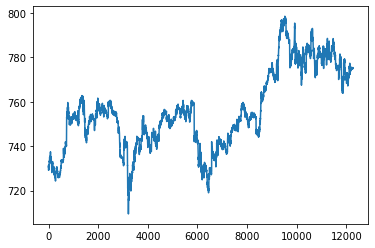

In [19]:
#Plot Verification of DFs, based on selection
plt.plot(Testing_df)

In [20]:
#Transform DF into a scalable form for the value to pull accurate predictions
scaler=MinMaxScaler(feature_range=(0,1))
Testing_df=scaler.fit_transform(np.array(Testing_df).reshape(-1,1))
print(Testing_df)

[[0.23643106]
 [0.23620632]
 [0.24710642]
 ...
 [0.7382852 ]
 [0.73839757]
 [0.73615013]]


In [21]:
#Split the Dataset to training, and testing data, lets do 80/20 for now, but can be updated
training_pct = 0.80

training_size=int(len(LSTM_df_Open)*training_pct) 
test_size=len(LSTM_df_Open)-training_size 
train_data,test_data=LSTM_df_Open[0:training_size,:],LSTM_df_Open[training_size:len(LSTM_df_Open),:1]

#verifying the split and calculation
training_size,test_size

(9811, 2453)

In [22]:
#Function create_dataset to set it as an array for LSTM
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [23]:
# Reshaping the training/testing data to properly match the dimensions of LSTM
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

#verify the training data and features to calculate next value
print(X_train.shape), print(y_train.shape)

#verify the testing data and features to calculate next value
print(X_test.shape), print(ytest.shape) 

(9710, 100)
(9710,)
(2352, 100)
(2352,)


(None, None)

In [24]:
#Reshaping the data to pull in and match the dimensions of LSTM for Machine Learning
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#Stacked Model LSTM and processing with Layers

#Defining layers and features for the ML model to process the information
neurons = 50
timesteps = time_step #referenced above in reshaping block (currently 100)
data_dimension = 1
dense_layer = 1

#LSTM Model Call, and pull of different layers to run RNN
model=Sequential()
model.add(LSTM(neurons,input_shape=(timesteps, data_dimension),return_sequences=True))
model.add(LSTM(neurons,return_sequences=True))
model.add(LSTM(neurons))
model.add(Dense(dense_layer))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
#Review of Layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
#training the model, currently set to silent mode, this will take time to process
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
152/152 [==============================] - 15s 98ms/step - loss: 7.4518e-05 - val_loss: 1.9457e-04
Epoch 2/100
152/152 [==============================] - 15s 97ms/step - loss: 7.5047e-05 - val_loss: 8.7952e-05
Epoch 3/100
152/152 [==============================] - 15s 98ms/step - loss: 8.2752e-05 - val_loss: 1.9047e-04
Epoch 4/100
152/152 [==============================] - 15s 100ms/step - loss: 6.9296e-05 - val_loss: 8.1171e-05
Epoch 5/100
152/152 [==============================] - 15s 98ms/step - loss: 7.4075e-05 - val_loss: 1.0085e-04
Epoch 6/100
152/152 [==============================] - 15s 99ms/step - loss: 6.2700e-05 - val_loss: 2.6407e-04
Epoch 7/100
152/152 [==============================] - 15s 99ms/step - loss: 6.9479e-05 - val_loss: 9.5153e-05
Epoch 8/100
152/152 [==============================] - 15s 101ms/step - loss: 8.0718e-05 - val_loss: 8.0491e-05
Epoch 9/100
152/152 [==============================] - 15s 97ms/step - loss: 6.5408e-05 - val_loss: 1.0650e-04

In [31]:
# Prediction and Performance Metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

#Calculate RMSE performance metrics - Root Mean Square Error, this is for the data set comparison
math.sqrt(mean_squared_error(y_train,train_predict))

750.1384368533301

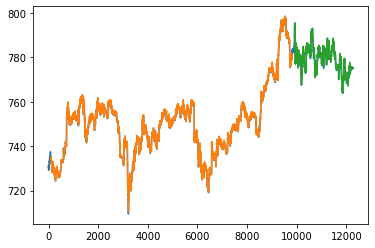

In [33]:
# Plotting 
# shift train predictions for plotting
look_back= timesteps #this is your timesteps from earlier
trainPredictPlot = np.empty_like(Testing_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(Testing_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(Testing_df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(Testing_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#orange is training
#green is predicting the test data and verifying

In [34]:
#converting the information to a list that has been scaled from 0 - 1 from earlier
test_values = test_size - timesteps

x_input=test_data[test_values:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
# demonstrate prediction for next 3
from numpy import array

lst_output=[]
n_steps=time_step
i=0
prediction_days = 3

while(i<prediction_days): #this predicts the next 30 days
    
    if(len(temp_input)>timesteps): 
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} price input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} price output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

tick_new=np.arange(1,timesteps + 1)
tick_pred=np.arange(timesteps + 1,timesteps + 1 + prediction_days)

[0.7391406]
101
1 day input [0.74131925 0.74289246 0.72345207 0.72446342 0.72210361 0.72435105
 0.7225531  0.72569952 0.73727385 0.74424093 0.7423306  0.73581301
 0.73783571 0.74367907 0.73199236 0.73862232 0.73862232 0.73952129
 0.73615013 0.72907068 0.72839645 0.73053152 0.72974492 0.72828408
 0.72839645 0.73053152 0.7301944  0.73277896 0.73334082 0.73199236
 0.73165524 0.73232948 0.73255422 0.73379031 0.73311608 0.73502641
 0.73446455 0.73232948 0.73232948 0.73379031 0.73277896 0.73232948
 0.73300371 0.73322845 0.73311608 0.73255422 0.73255422 0.73232948
 0.7322171  0.73154287 0.73176761 0.73187999 0.73187999 0.73210473
 0.7322171  0.73165524 0.73379031 0.73435217 0.73491404 0.73502641
 0.73502641 0.73525115 0.73558827 0.73603776 0.73592538 0.73615013
 0.73615013 0.73592538 0.73615013 0.73615013 0.73266659 0.73457692
 0.73480166 0.73603776 0.73210473 0.73536352 0.7342398  0.73435217
 0.73536352 0.73356557 0.73525115 0.73536352 0.73558827 0.73558827
 0.73615013 0.73513878 0.73603776 

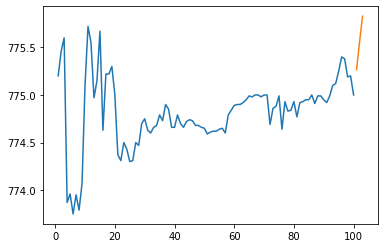

In [36]:
#Plotting the informatino with the prediction
tick_value = len(Testing_df) - timesteps

plt.plot(tick_new,scaler.inverse_transform(Testing_df[tick_value:]))
plt.plot(tick_pred,scaler.inverse_transform(lst_output)) #this is the predicted data / output (Orange Line)

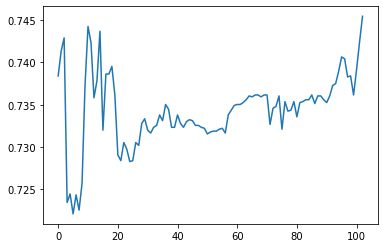

In [37]:
#Combining the information together for output
prediction_df = Testing_df.tolist()
prediction_df.extend(lst_output)
plt.plot(prediction_df [tick_value:])

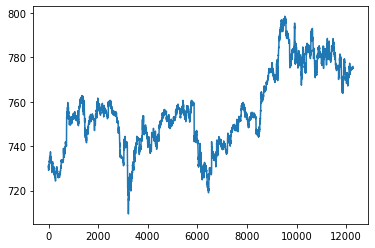

In [38]:
#Inverting the scaler back for actual values, and plotting the information
prediction_df = scaler.inverse_transform(prediction_df).tolist()
plt.plot(prediction_df)